# Meta-data

In [64]:
#OS libs
import os
import sys
from pathlib import Path
from io import StringIO
#Data handling libs
import pandas as pd
from tqdm import tqdm
from chess.pgn import read_game, BaseVisitor
import chess.engine
#Data visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator, FuncFormatter, LogLocator
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patches as mplp

#Meta-data
dt_pred_folder = os.path.join(os.getcwd(),'dt_chess','training_losses_k2')
state_emb_type = 'linear'
predictions = os.listdir(dt_pred_folder)
predictions = [x for x in predictions if x.partition('_')[0] == state_emb_type]
k_value = 'k2.csv'
predictions = [x for x in predictions if x.rpartition('_')[-1] == k_value]
predictions

['linear_1_400_Jiyarkhan_k2.csv']

# Filter prediction files

In [65]:
def filter_by(files, num_users = 0, user = 0):
    if num_users:
        filtered_files = [x for x in files if int(x.split('_')[1]) == num_users]
        # Sort ascending
        filtered_files.sort(key=lambda x: int(x.split('_')[2]),
                                  reverse=True)
        return filtered_files
    elif user:
        filtered_files = [x for x  in files if int(x.split('_')[2]) == user]
        # Sort ascending
        filtered_files.sort(key=lambda x: int(x.split('_')[1]))
        return filtered_files
    else:
        raise ValueError()
#first_user = filter_by(predictions, user=400)

# First model/user analysis

In [66]:
first_user = filter_by(predictions, user=400)
mu_1 = first_user[0]
mu_1

'linear_1_400_Jiyarkhan_k2.csv'

## Accuracy

In [67]:
pred_df = pd.read_csv(os.path.join(dt_pred_folder,
                                   mu_1),
                      index_col=None)

original_total = len(pred_df)
tp1_original = len(pred_df[pred_df['move'] == pred_df['engine_move_1']])
tp2_original = len(pred_df[pred_df['move'] == pred_df['engine_move_2']])
tp3_original = len(pred_df[pred_df['move'] == pred_df['engine_move_3']])
fp_original = len(pred_df[pred_df['illegal_top_move']])
tn_original = original_total - (tp1_original + tp2_original + tp3_original)
#tn_original = pred_df[~pred_df[['engine_move_1', 'engine_move_2', 'engine_move_3']].isin(pred_df['move']).any(1)]
print(f"total: {original_total:,} tp1: {tp1_original:,} "
      f"tp2: {tp2_original:,} tp3: {tp3_original:,} "
      f"fp: {fp_original:,} tn: {tn_original:,} "
      f"tn1: {original_total-tp1_original:,} acc: {(tp1_original/original_total)*100:,f}%")

total: 131,712 tp1: 131,709 tp2: 2 tp3: 0 fp: 8 tn: 1 tn1: 3 acc: 99.997722%


tp1 - Model's number 1 choice is the correct move\
tp2 - Model's number 2 choice is the correct move\
tp3 - Model's number 3 choice is the correct move\
fp - Highest probability in prediction vector is for an illegal move\
tn - The correct move is not in the model's top 3 choices\
tn1 - The correct move is not in the model's number 1 choice\
acc - Model's accuracy

### Removing unneccesarry predictions

In [68]:
# Duplicate position-move
pred_df_mod = pred_df.drop_duplicates()
num_duplicates = original_total - len(pred_df_mod)
print(f'Number of duplicates: {num_duplicates:,}\n'
      f'Non-duplicates total: {original_total-num_duplicates:,}')

Number of duplicates: 0
Non-duplicates total: 131,712


In [69]:
# Common position-move with train data
# %% Train data
train_datasets = os.listdir(os.path.join(os.getcwd(),
                                         'dt_chess',
                                         'datasets'))
train_data = [x for x in train_datasets if x.partition('_')[0] == mu_1.split('_')[2]][0]
train_df = pd.read_csv(os.path.join(os.getcwd(),
                                    'dt_chess',
                                    'datasets',
                                    train_data),
                       index_col=(0))
train_df.rename(columns={'positions': 'board', 'moves': 'move'}, inplace=True)
train_df.drop_duplicates(inplace=True)
pred_df_fin = pd.merge(pred_df_mod, train_df,
                       on=["board","move"], how='left',
                       indicator='Exist')
common_total = len(pred_df_fin[pred_df_fin['Exist'] == 'both'])
pred_df_fin = pred_df_fin[pred_df_fin['Exist'] == 'left_only']
pred_df_fin.drop('Exist', inplace=True, axis=1)
print(f'Common positions with train data: {common_total:,}\n'
      f'Total predictions (unique position-moves): {len(pred_df_fin):,}')

Common positions with train data: 6,268
Total predictions (unique position-moves): 125,444


### Accuracy - unique position-moves

In [70]:
total = len(pred_df_fin)
tp1 = len(pred_df_fin[pred_df_fin['move'] == pred_df_fin['engine_move_1']])
tp2 = len(pred_df_fin[pred_df_fin['move'] == pred_df_fin['engine_move_2']])
tp3 = len(pred_df_fin[pred_df_fin['move'] == pred_df_fin['engine_move_3']])
fp = len(pred_df_fin[pred_df_fin['illegal_top_move']])
tn = original_total - (tp1_original + tp2_original + tp3_original)
#tn_original = pred_df[~pred_df[['engine_move_1', 'engine_move_2', 'engine_move_3']].isin(pred_df['move']).any(1)]
print(f"total: {total:,} tp1: {tp1:,} "
      f"tp2: {tp2:,} tp3: {tp3:,} "
      f"fp: {fp:,} tn: {tn:,} "
      f"tn1: {total-tp1:,} acc: {(tp1/total)*100:,f}%")

total: 125,444 tp1: 125,441 tp2: 2 tp3: 0 fp: 7 tn: 1 tn1: 3 acc: 99.997608%


## Train loss

In [63]:
loss_df = pd.read_csv(os.path.join(os.getcwd(),'dt_chess',
                                   'training_losses_k2','linear_400_Jiyarkhan_k2_train_loss.csv'),
                      header=0)
loss_df.head()

,400_Jiyarkhan
0,8.495592
1,8.349093
2,8.272376
3,8.188091
4,8.165821


In [30]:
print(f"Max train loss: {loss_df.max()[0]:f}\n"
      f"Min train loss: {loss_df.min()[0]:f}")

Max train loss: 8.495592
Min train loss: 0.000023


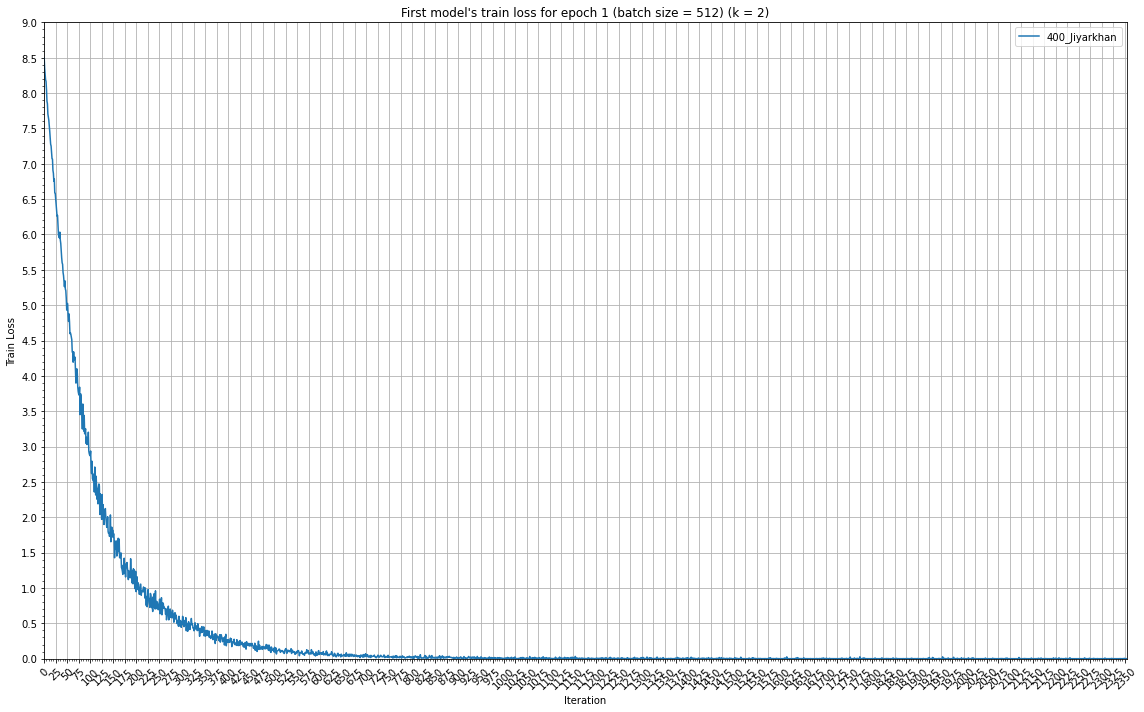

In [31]:
%matplotlib inline
def round_up(x, base=5):
    result = x + ((base - x) % base)
    # In this perticular case hard cap to 100
    # because we are working with accuracy
    if result > 100:
       result = 100
    return result

#PDF plot
plt.figure(figsize=(16, 10))
ax = sns.lineplot(data = loss_df)
ax.set(xlabel='Iteration')
ax.set(ylabel='Train Loss')
#Set major and minor ticks
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(axis='y', which='both', left=True)
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis='x', which='both', bottom=True)
ax.tick_params(axis="x", which="both", rotation=45)
#Extend y-limits
plt.ylim(0,round_up(loss_df.max()[0],1))
#Tighted x-limits
plt.xlim(0,len(loss_df)-1)
#Set grid
plt.grid(visible = True, which = 'major', axis = 'y', linestyle = '-',zorder=0)
plt.grid(visible = True, which = 'major', axis = 'x', linestyle = '-',zorder=0)
plt.title(f"First model's train loss for epoch 1 (batch size = 512) (k = 2)")
plt.tight_layout()
plt.show()

In [57]:
print(f"Number of iterations (batches):{len(loss_df):,}\n"
      f"Number of positions trained on*: {len(loss_df)*512:,}\n"
      f"First batch to reach min train loss ({loss_df.min()[0]:f}): {loss_df.idxmin()[0]:,}\n"
      f"Number of positions to this batch: {loss_df.idxmin()[0]*512:,}\n"
      f"First batch to reach train loss < 0.01: {loss_df.le(0.01).idxmax()[0]}\n"
      f"Number of positions to this batch:: {loss_df.le(0.01).idxmax()[0]*512:,}\n"
      "*Total number of position is slightly smaller because last batch is not whole")

Number of iterations (batches):2,355
Number of positions trained on*: 1,205,760
First batch to reach min train loss (0.000023): 2,354
Number of positions to this batch: 1,205,248
First batch to reach train loss < 0.01: 758
Number of positions to this batch:: 388,096
*Total number of position is slightly smaller because last batch is not whole
